In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

import torch as nn
import cv2

---

## Dataset

In [13]:
from collections import defaultdict


def parse_activities(string: str) -> list[str]:
    while string.find(r"(") >= 0:
        first_br = string.find(r"(")
        if (first_br > 0):
            second_br = string.find(r")")
            if second_br > 0:
                string = string[:first_br] + string[second_br+2:]
            else:
                string = string[:first_br]

    return [sub.strip() for sub in string.split(',')]


def get_activities(df: pd.DataFrame):
    categories = set(df['Category'].unique())

    activities = set()
    for _, row in df.iterrows():
        row_activities = parse_activities(row['Activity'])
        activities.update(row_activities)

    categories = list(categories)
    activities = list(activities)

    cat2act = {i: set() for i in range(len(categories))}
    for _, row in df.iterrows():
        row_activities = parse_activities(row['Activity'])
        row_category = row['Category']
        cat2act[categories.index(row_category)].update([activities.index(i) for i in row_activities])

    return np.array(categories), \
           np.array(activities), \
           {i: sorted(np.array(list(st))) for i, st in cat2act.items()}

In [14]:
cat, act, cat2act = get_activities(pd.read_csv('./var_13.csv'))

intersections = defaultdict(set)
for cat_idx1, act_idxs1 in cat2act.items():
    for cat_idx2, act_idxs2 in cat2act.items():
        if cat_idx1 != cat_idx2:
            inter = set(act_idxs1) & set(act_idxs2)
            if len(inter) > 0:
                for a in inter:
                    if len(intersections) == 0:
                        intersections[a] = set([cat_idx1, cat_idx2])
                    elif set([cat_idx1, cat_idx2]) not in intersections.values():
                        intersections[a].update(set([cat_idx1, cat_idx2]))

print("Пересекающиеся активности:")
for a, c in intersections.items():
    cats = ', '.join([f"'{cat[i]}'" for i in c])
    print(f"   \'{act[a]}\' -> {cats}")

Пересекающиеся активности:
   'standing' -> 'miscellaneous', 'occupation'
   'rowing' -> 'water activities', 'conditioning exercise'
   'general' -> 'walking', 'bicycling', 'home repair', 'winter activities', 'sports', 'occupation', 'home activities'
   'bicycling' -> 'conditioning exercise', 'bicycling'
   'carpentry' -> 'occupation', 'home repair'
   'moderate effort' -> 'lawn and garden', 'home activities'


In [66]:
from torch.utils.data import Dataset


keypoints_cols = ['r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 
                  'l knee_X', 'l knee_Y', 'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X', 'thorax_Y', 
                  'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y', 'r wrist_X', 'r wrist_Y', 'r elbow_X', 'r elbow_Y', 
                  'r shoulder_X', 'r shoulder_Y', 'l shoulder_X', 'l shoulder_Y', 'l elbow_X', 'l elbow_Y', 'l wrist_X', 'l wrist_Y']

class BodyKeypointsDataset(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        self.dataframe = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform

        self.catecories, self.activities, self.cat2actIds = get_activities(self.dataframe)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if nn.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.loc[idx, 'NAME'])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        landmarks = self.dataframe.loc[idx, keypoints_cols]
        landmarks = np.array([landmarks], dtype=np.float32).reshape(-1, 2)

        row_activities = parse_activities(self.dataframe.loc[idx, 'Activity'])
        activities = np.array([1.0 if act in row_activities else 0.0 for act in self.activities], dtype=np.float32)

        sample = {'image': image, 'landmarks': landmarks, 'target': activities}

        if self.transform:
            sample = self.transform(sample)

        return sample

1) Image size: (720, 1280, 3), Landmarks: (16, 2)
2) Image size: (720, 1280, 3), Landmarks: (16, 2)
3) Image size: (720, 1280, 3), Landmarks: (16, 2)
4) Image size: (1080, 1920, 3), Landmarks: (16, 2)
5) Image size: (720, 1280, 3), Landmarks: (16, 2)
6) Image size: (720, 1280, 3), Landmarks: (16, 2)
7) Image size: (720, 1280, 3), Landmarks: (16, 2)
8) Image size: (720, 1280, 3), Landmarks: (16, 2)
9) Image size: (720, 960, 3), Landmarks: (16, 2)


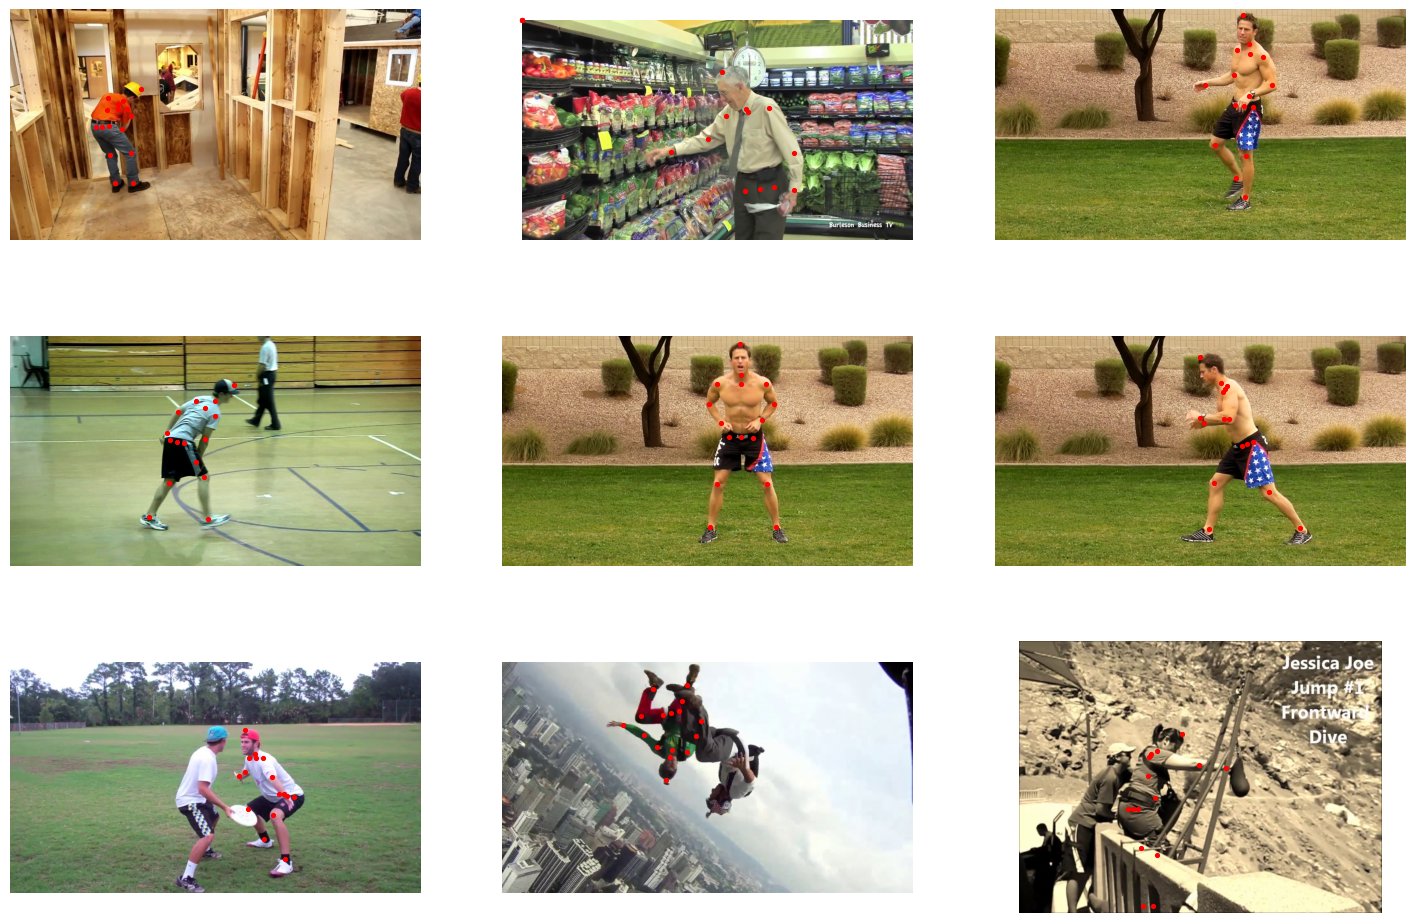

In [72]:
face_dataset = BodyKeypointsDataset(csv_path='./var_13.csv',
                                    root_dir='./dataset/')


def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=30, marker='.', c='r')


plt.figure(figsize=(18, 12), frameon=False)
for i, sample_idx in enumerate(np.random.choice(len(face_dataset), size=9)):
    sample = face_dataset[sample_idx]
    print(f"{i+1}) Image size: {sample['image'].shape}, Landmarks: {sample['landmarks'].shape}")

    plt.subplot(3, 3, i + 1)
    show_landmarks(sample['image'], sample['landmarks'])
    plt.axis('off')